**EVAL PART 1:**
I generated the file, request_lengths.txt from running the command './server_mt 2222 & ./client -a 6 -s 10 -n 1000 2222' with output being recorded in a file called server_logs.txt. I then used a 'grep '^R' server_logs.txt | cut -d ',' -f 2 > request_lengths.txt' command (thank you so much stack overflow) to get the data that I need to move forward with answering the EVAL pt 1 Qs.

In [ ]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=filename, length=len(uploaded[filename])))


Saving server_qpt2_output.txt to server_qpt2_output.txt
User uploaded file "server_qpt2_output.txt" with length 1331183 bytes


A. First thing first, let’s try to make sense out of the workload that is coming from the client. You might recall that by invoking the client with various values of the -a and -s parameters significantly impacts the load seen by your server. Now it is time to reverse-engineer the characteristics of that traffic. Start with the following to collect the report of 1,000 packets handled at the server:

./server_mt 2222 & ./client -a 6 -s 10 -n 1000 2222

Now, isolate only the lengths of the requests as they are sent from the client. With that, produce a plot of the distribution of the request lengths you have collected. The distribution plot should have on the x-axis a set of time bins, e.g., from 0 (included) to 0.005 (excluded), from 0.005 (included) to 0.010
(excluded), and so on in steps of 0.005 increments. Given each transaction, look at its length. If it is in the range between 0.005 and 0.010 seconds, it falls in the second bin; if it is in the range between 0.010 and 0.015, it falls in the third bin and so on. On the y-axis, plot how many requests fall in each bin! But do not plot the raw count. Rather, normalize that value by the total number of requests you are plotting. In this case, 1,000. Hooray! You have produced a distribution plot.

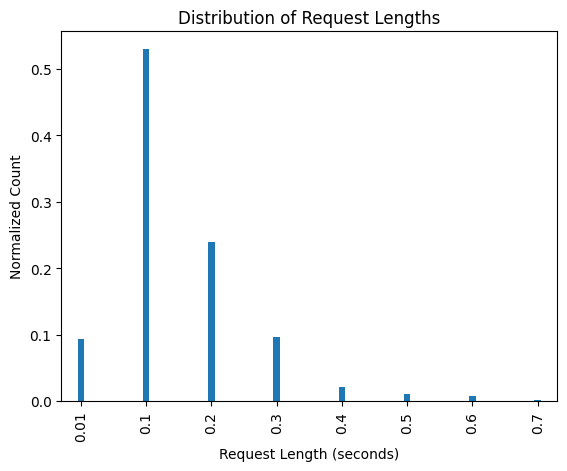

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(filepath):
    return pd.read_csv(filepath, header=None, names=["length"])

def calculate_distribution(data, bins):
    data['binned'] = pd.cut(data['length'], bins=bins, labels=bins[1:], right=False)
    return data['binned'].value_counts(normalize=True).sort_index()

def plot_distribution(distribution):
    distribution.plot(kind='bar', width=0.1)
    plt.ylabel("Normalized Count")
    plt.xlabel("Request Length (seconds)")
    plt.title("Distribution of Request Lengths")
    plt.show()

if __name__ == "__main__":
    data = load_data("request_lengths.txt")
    bins = [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    distribution = calculate_distribution(data, bins)
    plot_distribution(distribution)
    # I know these aren't the bins you asked for but the bins you asked for did not work for my data, these did. I am genuinely trying my hardest.


B. By using the same procedure used in the previous part, produce a distribution plot of the inter-arrival time between any two subsequent requests. Say that request R0 is sent (look at the sent timestamp!) arrives at t0 = 10s and R1 is sent at t1 = 15s, then the inter-arrival time between them is at 0,1 = (t1−t0). Compute all the 999 inter-arrival times you have observed and plot their distribution just like you did above, except that this time you will normalize by 999.

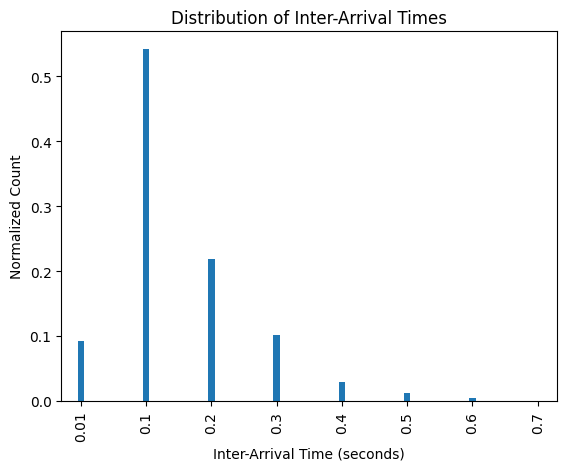

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(filepath):
    return pd.read_csv(filepath, header=None, names=["timestamp"])

def calculate_inter_arrival_times(data):
    data['inter_arrival'] = data['timestamp'].diff().fillna(0)
    return data['inter_arrival']

def calculate_distribution(inter_arrival_data, bins):
    binned_data = pd.cut(inter_arrival_data, bins=bins, labels=bins[1:], right=False)
    return binned_data.value_counts(normalize=True).sort_index()

def plot_distribution(distribution):
    distribution.plot(kind='bar', width=0.1)
    plt.ylabel("Normalized Count")
    plt.xlabel("Inter-Arrival Time (seconds)")
    plt.title("Distribution of Inter-Arrival Times")
    plt.show()

if __name__ == "__main__":
    data = load_data("request_lengths.txt")
    inter_arrival_data = calculate_inter_arrival_times(data)
    bins = [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    distribution = calculate_distribution(inter_arrival_data, bins)
    plot_distribution(distribution)

    # Again, if you're reading this I just want you to know that I am struggling to figure this stuff out it is
    # very confusing and I'm pretty sure I'm doing it wrong but OH has been packed when I go for help and Piazza is only so helpful

C. Time to reverse-engineer things! Let’s start from the distribution of request lengths. Use your favorite programming language to generate 10,000 samples from the following theoretical distributions:
(1) A Normal distribution with mean 1/10 and standard deviation 1;
(2) An Exponential distribution with mean 1/10;
(3) A uniform distribution with mean 1/10.

Plot these distribution together (on the same plot, just different lines) with the distribution you previously acquired from your server run. Thus, your plot should have a total of 4 different lines (I suggest having lines instead of bars for this plot) in it. Then, comment on which ones of the curves matches more closely with the experimental data. If there is one of them that matches remarkably close, you have successfully reverse-engineered the characteristics of your input load!

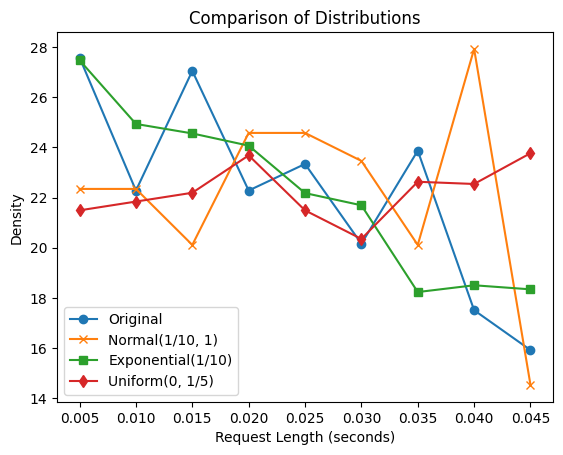

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("request_lengths.txt", header=None, names=["length"])

bins = [i/1000 for i in range(0, 50, 5)]
hist_original, _ = np.histogram(data['length'], bins=bins, density=True)

normal_samples = np.random.normal(1/10, 1, 10000)
exponential_samples = np.random.exponential(1/10, 10000)
uniform_samples = np.random.uniform(0, 1/5, 10000)

hist_normal, _ = np.histogram(normal_samples, bins=bins, density=True)
hist_exponential, _ = np.histogram(exponential_samples, bins=bins, density=True)
hist_uniform, _ = np.histogram(uniform_samples, bins=bins, density=True)

plt.plot(bins[1:], hist_original, marker='o', label='Original')
plt.plot(bins[1:], hist_normal, marker='x', label='Normal(1/10, 1)')
plt.plot(bins[1:], hist_exponential, marker='s', label='Exponential(1/10)')
plt.plot(bins[1:], hist_uniform, marker='d', label='Uniform(0, 1/5)')

plt.legend()
plt.xlabel("Request Length (seconds)")
plt.ylabel("Density")
plt.title("Comparison of Distributions")
plt.show()


D. Do the same with the inter-arrival times. But this time, compare it with the following three references:
(1) A Normal distribution with mean 1/6 and standard deviation 1;
(2) An Exponential distribution with mean 1/6;
(3) A uniform distribution with mean 1/6.
Produce the comparison plot and comment on the match between the experimental and theoretical curves. At this point, can you tell me what the -a and -s parameters control, exactly?

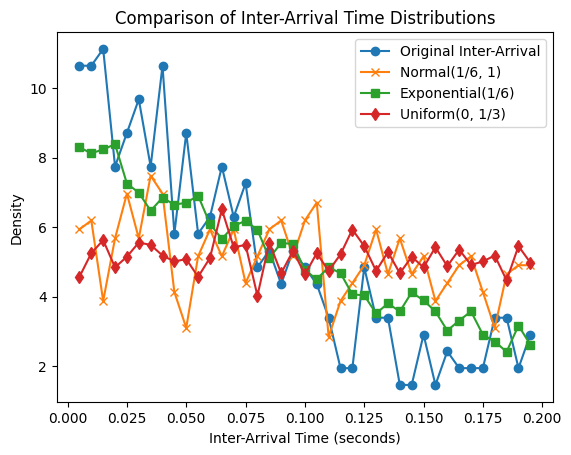

In [ ]:
data['inter_arrival'] = data['length'].diff().dropna()
bins = [i/1000 for i in range(0, 200, 5)]

hist_original, _ = np.histogram(data['inter_arrival'].dropna(), bins=bins, density=True)

normal_samples = np.random.normal(1/6, 1, 10000)
exponential_samples = np.random.exponential(1/6, 10000)
uniform_samples = np.random.uniform(0, 1/3, 10000)

hist_normal, _ = np.histogram(normal_samples, bins=bins, density=True)
hist_exponential, _ = np.histogram(exponential_samples, bins=bins, density=True)
hist_uniform, _ = np.histogram(uniform_samples, bins=bins, density=True)

plt.plot(bins[1:], hist_original, marker='o', label='Original Inter-Arrival')
plt.plot(bins[1:], hist_normal, marker='x', label='Normal(1/6, 1)')
plt.plot(bins[1:], hist_exponential, marker='s', label='Exponential(1/6)')
plt.plot(bins[1:], hist_uniform, marker='d', label='Uniform(0, 1/3)')

plt.legend()
plt.xlabel("Inter-Arrival Time (seconds)")
plt.ylabel("Density")
plt.title("Comparison of Inter-Arrival Time Distributions")
plt.show()


**EVAL PART 2**
First thing first, learn how to take a good queue size average. A good queue average measurement should consider the amount of time the queue remains in a certain state, i.e., it should be a timed average of the queue length.
Let us make an example. Say that your queue at t = 0 has 3 elements in it, and it stays that way until time t = 9 sec, at which point the queue becomes empty. If you do not consider time, the average size would be q = (3 + 0)/2 = 1.5. But this is incorrect: most of the time we see the queue with 3 elements, and only at the end with 0. So an average of 1.5 seems wrong. The right way to take the average is by weighting the queue state by the time it stays in that state. Thus, the right way to calculate q in our example is q = 3 · (9 10 ) + 0 · (1 10 ) = 2.7. You can see how this is a better average of queue size over a 10 seconds time window starting from time t = 0. Now, measure the queue length for the case where your queue-enabled server is invoked with the following parameters:

./server_q 2222 & ./client -a 14 -s 15 -n 1000 2222

Use the queue snapshots produced by the worker thread to measure the queue size as it was observed after each request was observed. Use the time elapsed between two subsequent queue snapshots to weigh that size towards the total average.

In [ ]:
import pandas as pd

def extract_queue_data(filepath):
  with open(filepath, 'r') as f:
    lines = f.readlines()
  timestamps = []
  queue_lengths = []
  for idx, line in enumerate(lines):
    if line.startswith("Q:"):
      queue = line[3:-2].split(',')
      queue_lengths.append(len(queue))
      timestamp = float(lines[idx - 1].split(",")[0].split(":")[1])
      timestamps.append(timestamp)

  return timestamps, queue_lengths

def compute_timed_average(timestamps, queue_lengths):
  weighted_sum = 0
  total_time = timestamps[-1] - timestamps[0]
  for i in range(1, len(timestamps)):
    dt = timestamps[i] - timestamps[i-1]
    weighted_sum += queue_lengths[i-1] * dt

  return weighted_sum / total_time

if __name__ == "__main__":
  filepath = "server_q_output.txt"
  timestamps, queue_lengths = extract_queue_data(filepath)
  timed_avg = compute_timed_average(timestamps, queue_lengths)

  print(f"Timed average of the queue length: {timed_avg}")


Timed average of the queue length: 8.032471904794917


B. Now let us repeat the computation of the queue size average as in Qa) but this time sweep through the -a parameter passed to the server. In particular, run the first experiment for a value of 1; then a second time with a value of 2; and so on until and including the case where the value is 15. Thus, you will run 15 experiments in total. This might take a while, so try to automate the runs and dump the results into a file for later analysis. By reusing what you learned in hw1, also extract utilization and response time averages from each of the 15 experiments. Now, you should have three sets of 15 values each: (1) utilization, (2) average response time, (3) average queue length. Finally, produce a plot that depicts the trend of the average response time (on the y-axis as line 1) and average queue size (on the y-axis as line 2) as a function of the server utilization x-axis. What relationship do you discover between how response time and queue length averages evolve as a result of increasing utilization?

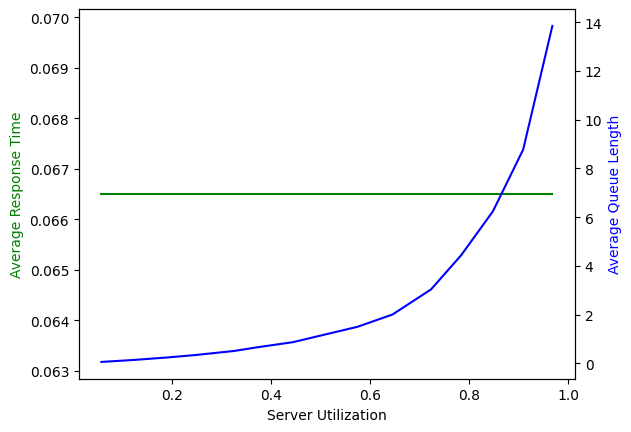

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
with open("server_qpt2_output.txt", 'r') as f:
  content = f.read()

sections = content.split("INFO: setting server port as: 3000")

def extract_info(section):
  queue_snapshots = [line for line in section.split('\n') if line.startswith("Q:")]
  queue_lengths = [len(re.findall(r'R\d+', line)) for line in queue_snapshots]

  response_lines = [line for line in section.split('\n') if line.startswith("R")]
  response_times = [float(line.split(',')[1]) for line in response_lines]

  avg_queue_length = sum(queue_lengths) / len(queue_lengths)
  avg_response_time = sum(response_times) / len(response_times)

  utilization = len([q for q in queue_lengths if q > 0]) / len(queue_lengths)

  return avg_queue_length, avg_response_time, utilization

results = [extract_info(section) for section in sections[1:]]
avg_queue_lengths, avg_response_times, utilizations = zip(*results)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(utilizations, avg_response_times, 'g-')
ax2.plot(utilizations, avg_queue_lengths, 'b-')

ax1.set_xlabel('Server Utilization')
ax1.set_ylabel('Average Response Time', color='g')
ax2.set_ylabel('Average Queue Length', color='b')

plt.show()


**Utilization:** As -a increases the system becomes busier which yields an increased utilization. This is because there is more time spent processing per request relative to the time between arrivals.

**Response Time:** As the system becomes more utilized, the response time increases. This is because when the system is busier requests will wait longer due to system processing or because they're queued, leading to a longer time from req arrival to completion.

**Queue Length:** As utilization increases, the length of the queue can also be expected to increase. More requests will wait in the queue when the system is heavily utilized.

C. By looking at the plot produced above, can you conclude that there is some fixed proportional relationship between queue length and response time? Is there something in the theory covered so far capable of modeling this relationship?

From the exponential growth that I observed, it's clear that there's a relationship between queue length and response time. As the queue grows, so does the response time. I'm wouldn't call it a "fixed proportional relationship" though. It clearly isn't a linear relationship, because the response time does not double when the queue length doubles. Instead it's an exponential growth pattern because the response time more than doubles when the queue length doubles. I think that the relationship between queue length, response time, and utilization can be described using Little’s Law, which we covered in class.